[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


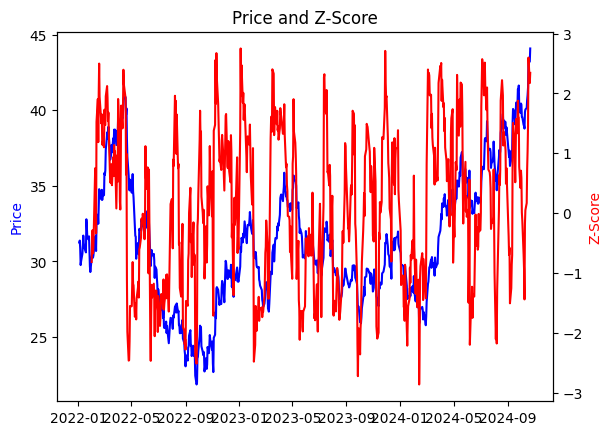

Z-Score: 2.343440923387355, Confidence: 1.91%
Monte Carlo Confidence: 49.00%
No trade - Confidence below threshold


In [65]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
# from pyrh import Robinhood

# Constants for the strategy
TRADING_DAYS = 5  # Holding period for trades (Monday - Friday)
MAX_POSITION_SIZE = 100  # Maximum trade size
RISK_ADJUSTMENT_FACTOR = 0.5  # Risk scaling factor for leverage
CONFIDENCE_THRESHOLD = 0.7  # Minimum confidence to enter a trade

# Robinhood login (replace with your credentials)
# robinhood = Robinhood()
# robinhood.login(username='your_username', password='your_password')

# 1. Download historical data for GDX and Gold
def get_data(ticker, start='2022-01-01', end='2024-10-23'):
    return yf.download(ticker, start=start, end=end)['Close']

gdx = get_data('GDX')
gold = get_data('GC=F')

# 2. Calculate Z-Score and Reversion Probability
def calculate_z_score(price, mean, std_dev):
    return (price - mean) / std_dev

def reversion_probability(z_score):
    return 2 * (1 - norm.cdf(abs(z_score)))

# 3. Monte Carlo Simulation for Confidence Estimation
def monte_carlo_simulation(current_price, mean, std_dev, simulations=1000):
    results = np.zeros(simulations)
    for i in range(simulations):
        simulated_path = np.random.normal(mean, std_dev, TRADING_DAYS)
        results[i] = simulated_path[-1]  # Final simulated price
    # Calculate the probability of mean reversion
    reversion_count = np.sum(results < mean)
    return reversion_count / simulations

# 4. Calculate Leverage and Trade Size Based on Confidence
def calculate_leverage(confidence):
    return min(confidence / RISK_ADJUSTMENT_FACTOR, 3)  # Cap leverage at 3x

def calculate_trade_size(confidence):
    return int(MAX_POSITION_SIZE * confidence)

# 5. Plot Historical Prices and Z-Score for Visualization
def plot_price_and_z_score(data, z_scores):
    fig, ax1 = plt.subplots()
    ax1.plot(data, label='Price', color='blue')
    ax1.set_ylabel('Price', color='blue')
    ax2 = ax1.twinx()
    ax2.plot(z_scores, label='Z-Score', color='red')
    ax2.set_ylabel('Z-Score', color='red')
    plt.title('Price and Z-Score')
    plt.show()

# 6. Trading Logic
def trading_logic():
    # Calculate rolling mean and std deviation (20-day window)
    mean = gdx.rolling(window=20).mean()
    std_dev = gdx.rolling(window=20).std()
    
    # Current price, mean, and std deviation
    current_price = gdx.iloc[-1]
    current_mean = mean.iloc[-1]
    current_std_dev = std_dev.iloc[-1]

    # Calculate Z-Score and Confidence
    z_score = calculate_z_score(current_price, current_mean, current_std_dev)
    confidence = reversion_probability(z_score)

    print(f'Z-Score: {z_score}, Confidence: {confidence:.2%}')

    # Run Monte Carlo Simulation for additional confidence estimation
    monte_carlo_confidence = monte_carlo_simulation(current_price, current_mean, current_std_dev)
    print(f'Monte Carlo Confidence: {monte_carlo_confidence:.2%}')

    # Adjust final confidence using both Z-Score and Monte Carlo results
    final_confidence = (confidence + monte_carlo_confidence) / 2

    if final_confidence >= CONFIDENCE_THRESHOLD:
        # Calculate leverage and trade size
        leverage = calculate_leverage(final_confidence)
        trade_size = calculate_trade_size(final_confidence)
        print(f'Placing trade with leverage {leverage:.2f}x and trade size {trade_size}')
        
        # Place trade via Robinhood API
        place_trade('GDX', trade_size, leverage)
    else:
        print('No trade - Confidence below threshold')

# 7. Place Trade on Robinhood
def place_trade(ticker, trade_size, leverage):
    print(f'Placed trade for {trade_size} shares of {ticker} with leverage {leverage}x')
    # Calculate the number of shares to buy based on leverage
    # price = robinhood.quote_data(ticker)['last_trade_price']
    # shares = int(trade_size / float(price) * leverage)

    # Place a market order
    # robinhood.place_buy_order(ticker, shares)
    # print(f'Placed buy order for {shares} shares of {ticker}')

# 8. Run the Strategy
# if __name__ == '__main__':
    # Plot price and Z-Score for visualization
z_scores = (gdx - gdx.rolling(20).mean()) / gdx.rolling(20).std()
plot_price_and_z_score(gdx, z_scores)

# Execute trading logic
trading_logic()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

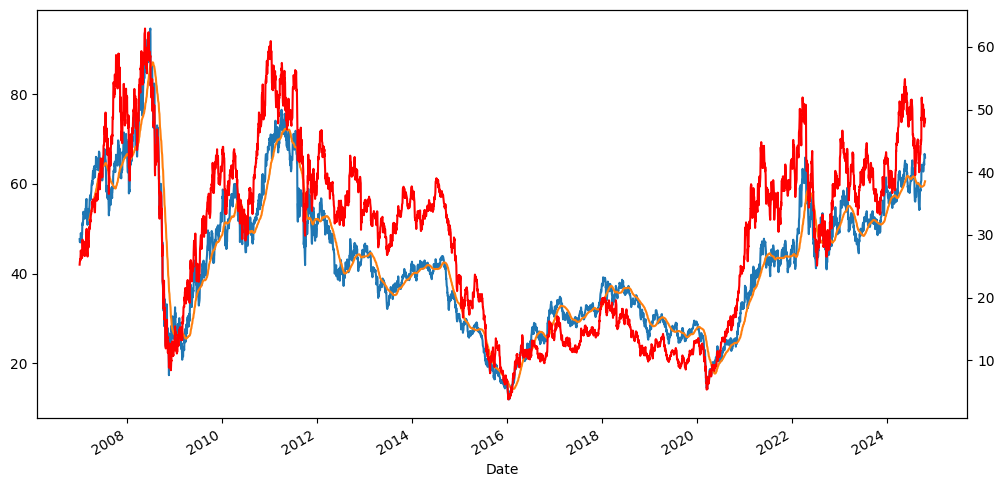

In [66]:
f = plt.figure(figsize=(12, 6))
ax = f.add_subplot(111)

s_and_p = get_data('XME', start='2007-01-01', end='2024-10-23')
s_and_p.plot(ax=ax)
s_and_p.rolling(52).mean().plot(ax=ax)

ax2 = ax.twinx()

freeport = get_data('FCX', start='2007-01-01', end='2024-10-23')
freeport.plot(ax=ax2, color='r')

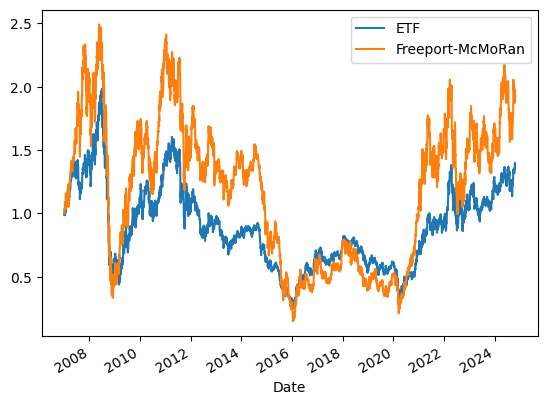

In [70]:
merged = pd.merge_asof(s_and_p, freeport, left_index=True, right_index=True)
merged.rename(columns={'Close_x': 'ETF', 'Close_y': 'Freeport-McMoRan'}, inplace=True)
merged_normalized = merged / merged.iloc[0]
merged_normalized["deviation"] = merged_normalized["ETF"] - merged_normalized["Freeport-McMoRan"]
merged_normalized["deviation_abs"] = merged_normalized["deviation"].abs()
merged_normalized[["ETF", "Freeport-McMoRan"]].plot()
plt.show()

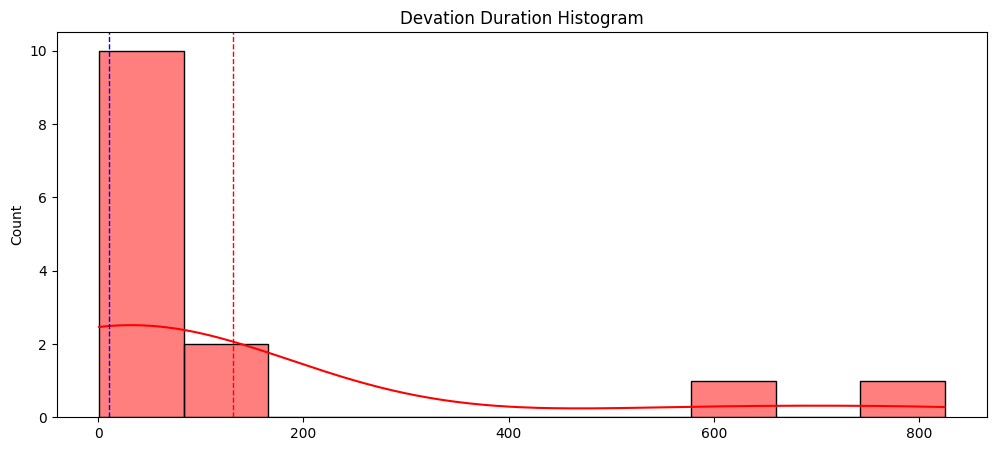

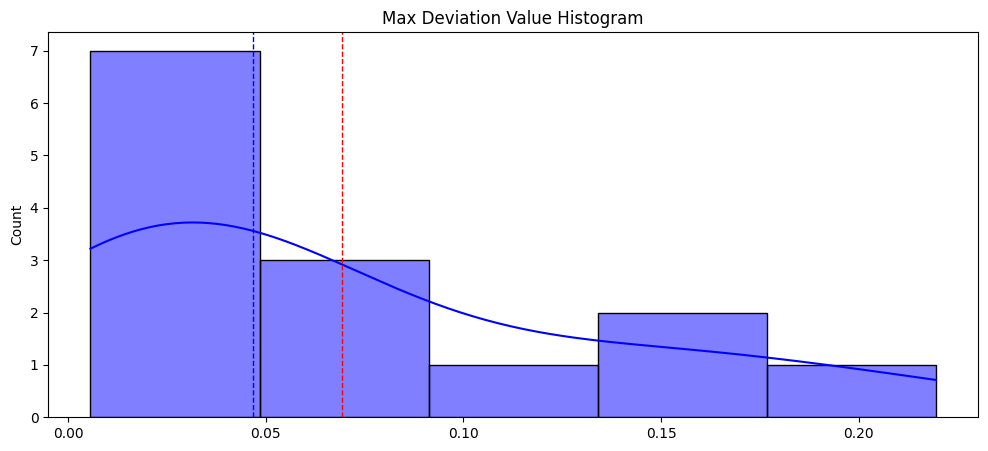

In [76]:
import seaborn as sns

# Let's modify the logic to correctly measure the devation cycles
# We're interested in:
# 1. **Duration**: Time from when the deviation exceeds the threshold until it returns below the threshold.
# 2. **Maximum Deviation Value**: The peak deviation value within that cycle.
df = merged_normalized
threshold = 0.001
# Initialize variables to store devation cycles
devation_cycles = []
max_deviation_values = []

# Track the state of a devation cycle
in_devation = False
devation_start = None
max_deviation = 0

# Iterate over the DataFrame to identify devation cycles
for i in range(len(df)):
    deviation = df['deviation'].iloc[i]
    date = df.index[i]

    if deviation > threshold:
        if not in_devation:
            # Start a new devation cycle
            in_devation = True
            devation_start = date
            max_deviation = deviation
        else:
            # Update the maximum deviation within the current cycle
            max_deviation = max(max_deviation, deviation)
    else:
        if in_devation:
            # End the devation cycle and record the duration and max deviation
            duration = (date - devation_start).days
            devation_cycles.append(duration)
            max_deviation_values.append(max_deviation)

            # Reset state for the next cycle
            in_devation = False
            devation_start = None
            max_deviation = 0

# Handle the case where a devation cycle ends on the last date
if in_devation:
    duration = (df.index[-1] - devation_start).days
    devation_cycles.append(duration)
    max_deviation_values.append(max_deviation)

# Plotting the histograms of:
# 1. devation Duration
# 2. Maximum Deviation within devation Cycles

plt.figure(figsize=(12, 5))
sns.histplot(devation_cycles, color='red', kde=True)
plt.axvline(np.mean(devation_cycles), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.median(devation_cycles), color='blue', linestyle='dashed', linewidth=1)
plt.title('Devation Duration Histogram')
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(max_deviation_values, color='blue', kde=True)
plt.axvline(np.mean(max_deviation_values), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.median(max_deviation_values), color='blue', linestyle='dashed', linewidth=1)
plt.title('Max Deviation Value Histogram')
plt.show()



# Display the results of devation cycles
# {
#     "devation_Durations": devation_cycles,
#     "Max_Deviation_Values": max_deviation_values,
# }


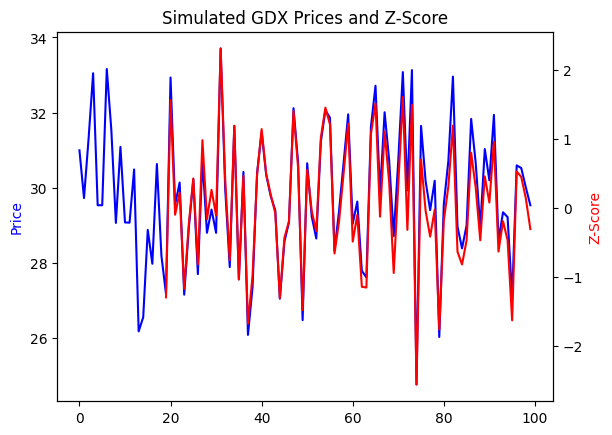

({'current_price': 29.530825733249706,
  'current_mean': 29.952256039102576,
  'current_std_dev': 1.38162144030868,
  'z_score': -0.30502588737962394,
  'confidence': 0.7603464359788301,
  'monte_carlo_confidence': 0.497,
  'final_confidence': 0.628673217989415},
 None)

In [69]:
# Let's conduct a dry-run of parts of the framework using sample data.
# Since Robinhood API requires credentials, I will simulate the core calculations,
# including Z-scores, Monte Carlo, and confidence calculations using test data.

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Sample historical data: GDX (simulated prices)
np.random.seed(42)  # For reproducibility
gdx_prices = np.random.normal(loc=30, scale=2, size=100)  # 100 days of GDX-like data

# Convert to pandas DataFrame for rolling calculations
gdx = pd.Series(gdx_prices)

# Calculate rolling mean and standard deviation (20-day window)
mean = gdx.rolling(window=20).mean()
std_dev = gdx.rolling(window=20).std()

# Use the latest data point as "current price"
current_price = gdx.iloc[-1]
current_mean = mean.iloc[-1]
current_std_dev = std_dev.iloc[-1]

# 1. Calculate Z-Score
def calculate_z_score(price, mean, std_dev):
    if std_dev == 0:  # Avoid division by zero
        return 0
    return (price - mean) / std_dev

z_score = calculate_z_score(current_price, current_mean, current_std_dev)

# 2. Calculate reversion probability from Z-Score
def reversion_probability(z_score):
    return 2 * (1 - norm.cdf(abs(z_score)))

confidence = reversion_probability(z_score)

# 3. Monte Carlo Simulation for additional confidence
def monte_carlo_simulation(current_price, mean, std_dev, simulations=1000):
    results = np.zeros(simulations)
    for i in range(simulations):
        simulated_path = np.random.normal(mean, std_dev, 5)  # 5-day future path
        results[i] = simulated_path[-1]  # Final price
    reversion_count = np.sum(results < mean)
    return reversion_count / simulations

monte_carlo_confidence = monte_carlo_simulation(current_price, current_mean, current_std_dev)

# Final confidence: Average of Z-score and Monte Carlo confidences
final_confidence = (confidence + monte_carlo_confidence) / 2

# Plot GDX prices and Z-scores for visualization
def plot_price_and_z_score(data, z_scores):
    fig, ax1 = plt.subplots()
    ax1.plot(data, label='Price', color='blue')
    ax1.set_ylabel('Price', color='blue')
    ax2 = ax1.twinx()
    ax2.plot(z_scores, label='Z-Score', color='red')
    ax2.set_ylabel('Z-Score', color='red')
    plt.title('Simulated GDX Prices and Z-Score')
    plt.show()

# Calculate Z-scores for all points to visualize
z_scores = (gdx - mean) / std_dev

# Display results and plot
{
    "current_price": current_price,
    "current_mean": current_mean,
    "current_std_dev": current_std_dev,
    "z_score": z_score,
    "confidence": confidence,
    "monte_carlo_confidence": monte_carlo_confidence,
    "final_confidence": final_confidence,
}, plot_price_and_z_score(gdx, z_scores)
